In [3]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [4]:
nm = 1e-3

thickness1 = 0.25*700*nm

def oblique_sim(theta=0):
    resolution = 100
    cell_size = mp.Vector3(4,0,2)

    pml_layer = [mp.PML(thickness = 0.5, direction= mp.X) ]

In [5]:
def planar_reflectance_single_angle(rot_angle, max_sim_time=100): # rotate()메소드는 입력으로 radian값을 받습니다. 그래서 함수의 정의는 radian값을 받도록 합니다.
    try:        
        cell = mp.Vector3(4, 2, 0) 
        resolution = 20
        pml_layers = [mp.PML(thickness=0.5, direction=mp.X)]

        Air = mp.Medium(index=1)
        SiO2 = mp.Medium(index=1.46)
        Si = mp.Medium(index=3.68)

        layer2_length = 0.25 * 0.7
        
        
        geometry = [mp.Block(mp.Vector3(4, mp.inf, mp.inf),
                     center = mp.Vector3(0, 0, 0),
                     material = mp.Medium(epsilon = 1)),
            ]

        fmax = 1 / 0.69
        fmin = 1 / 0.71
        fcen = 0.5 * (fmax + fmin)
        nfreq = 1

        k_point = mp.Vector3(fcen).rotate(mp.Vector3(z=1), rot_angle) # mp.Vector3에 rotate 메소드를 사용하여 rot_angle (rad) 만큼 축(z=1)에 대해 시계 방향으로 회전시킵니다.

        sources = [
            mp.EigenModeSource(
                src=mp.GaussianSource(frequency=(fmax + fmin) / 2, fwidth=fmax - fmin),
                center=mp.Vector3(-1.2, 0),
                size=mp.Vector3(0, 2),
                direction=mp.NO_DIRECTION, # k_point로 방향을 정하도록 설정
                eig_kpoint=k_point,
                eig_band=1,
                eig_match_freq=True,
            )
        ]
        
        sim5 = mp.Simulation(
            cell_size=cell,
            geometry=geometry,
            boundary_layers=pml_layers,
            sources=sources,
            resolution=resolution,
            dimensions=2,
        )

        refl_fr = mp.FluxRegion(center=mp.Vector3(-1, 0), size=mp.Vector3(0, 2))
        refl = sim5.add_flux((fmax + fmin) / 2, fmax - fmin, nfreq, refl_fr)
        
        tran_fr = mp.FluxRegion(center = mp.Vector3(0.05,0,0), size = mp.Vector3(0,2))
        tran = sim5.add_flux((fmax + fmin) / 2, fmax - fmin, nfreq, tran_fr)

        pt = mp.Vector3(1, 0)
        
        print("------------------------------------------------------------------------")
        print("Setting up first phase geometry")
        print("------------------------------------------------------------------------")

        sim5.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3), until=max_sim_time)

        tran_flux = mp.get_fluxes(refl)
        refl_data = sim5.get_flux_data(refl)
        
        

        sim5.reset_meep()
        
        print("------------------------------------------------------------------------")
        print("Setting up second phase geometry")
        print("------------------------------------------------------------------------")
        
        geometry2 = [mp.Block(mp.Vector3(2-layer2_length, mp.inf, mp.inf),
                     center = mp.Vector3(-layer2_length - 0.5*(2-layer2_length), 0, 0),
                     material = mp.Medium(epsilon = 1)),
            mp.Block(mp.Vector3(layer2_length, mp.inf, mp.inf),
                     center = mp.Vector3(-0.5*layer2_length, 0, 0),
                     material = SiO2),
            mp.Block(mp.Vector3(2, mp.inf, mp.inf),
                     center = mp.Vector3(1, 0, 0),
                     material = Si)]

        print("Reinitializing simulation object for second phase")
        sim5 = mp.Simulation(
            cell_size=cell,
            geometry=geometry2,
            boundary_layers=pml_layers,
            sources=sources,
            resolution=resolution,
            dimensions=2  
        )

        refl = sim5.add_flux((fmax+fmin)/2, fmax-fmin, nfreq, refl_fr)
        tran = sim5.add_flux((fmax+fmin)/2, fmax-fmin, nfreq, tran_fr)
        
        sim5.load_minus_flux_data(refl, refl_data)

        print("Running second phase of simulation")
        sim5.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3), until=max_sim_time)
        print("Second phase complete")
        
        # plt.figure(dpi=100)
        # sim5.plot2D()
        # plt.show()

        final_refl_flux = mp.get_fluxes(refl)
        final_tran_flux = mp.get_fluxes(tran)
        
        Rs2 = -final_refl_flux[0] / tran_flux[0]
        Ts2 = final_tran_flux[0] / tran_flux[0]

        return Rs2, Ts2
    
    except Exception as e:
        print(f"Error in planar_reflectance with angle {np.degrees(rot_angle)} degrees: {e}")
        return None

In [6]:
thetas = np.radians(np.linspace(-89,90,180)) # planar_reflectance_single_angle()에서 -89도에서 89도까지의 각도들을 입력값으로 사용하기 위해 모두 radian으로 변환하여 list로 저장합니다.
Rs2 = []
Ts2 = []

for j in range(len(thetas)):
    print("========================================================================")
    print(f"Running 2D simulation for theta = {np.degrees(thetas[j])} degrees")
    print(f"Theta (radians) = {thetas[j]}")
    print("========================================================================")
    Rs2_value, Ts2_value = planar_reflectance_single_angle(thetas[j], max_sim_time=100) # 함수를 호출했을 때 return되는 값을 Rs2_value에 저장합니다.

    if Rs2_value is not None:
        print(f"Reflectance at {np.degrees(thetas[j])} degrees: {Rs2_value}")
        Rs2.append(Rs2_value)
        Ts2.append(Ts2_value)
    else:
        print("Failed to compute reflectance at 0 degrees")

Running 2D simulation for theta = -89.0 degrees
Theta (radians) = -1.5533430342749532
------------------------------------------------------------------------
Setting up first phase geometry
------------------------------------------------------------------------
-----------
Initializing structure...
time for choose_chunkdivision = 8.60691e-05 s
Working in 2D dimensions.
Computational cell is 4 x 2 x 0 with resolution 20
     block, center = (0,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0283279 s
-----------
MPB solved for frequency_1(0.0249371,-1.42865,0) = 1.42886 after 4 iters
field decay(t = 50.025000000000006): 0.0003442233044996707 / 0.0003442233044996707 = 1.0
field decay(t = 100.05000000000001): 2.1980176335450965 / 2.1980176335450965 = 1.0
field decay(t = 150.07500000000002): 7.789408138920054 / 7.789408138920054 = 1.0
field decay(t = 200.10000000000002): 3.24904

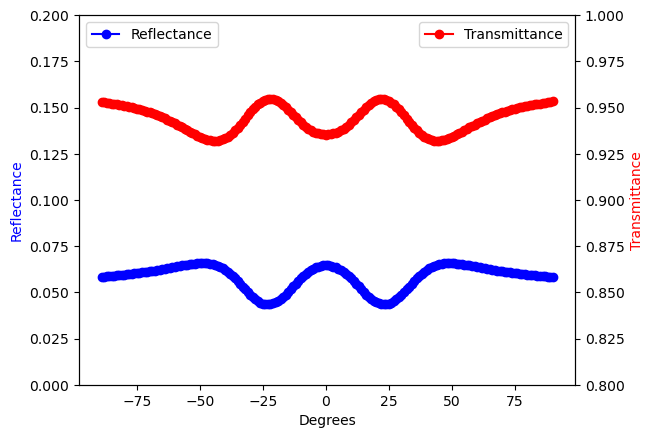

In [7]:
fig, ax1 = plt.subplots()

# Plot Rs2 on the left y-axis
ax1.plot(np.linspace(-89, 90, 180), Rs2, 'bo-', label='Reflectance')
ax1.set_xlabel("Degrees")
ax1.set_ylabel('Reflectance', color='b')
ax1.set_ylim(0, 0.2)
ax1.legend(loc="upper left")

# Create a second y-axis for Ts2
ax2 = ax1.twinx()
ax2.plot(np.linspace(-89, 90, 180), Ts2, 'ro-', label='Transmittance')
ax2.set_ylabel('Transmittance', color='r')
ax2.set_ylim(0.8, 1)
ax2.legend(loc="upper right")

plt.show()